<h3 align="right">mCP, &nbsp; dSPN, &nbsp; 150908_c5_D1, &nbsp; animal_1_n33_04102017_cel1 </h3>

# Model selection

## Model data

In [1]:
import cell_model, cell_evaluator
morphofile = 'morphology/animal_1_n33_04102017_cel1.swc'
parameters = cell_model.define_parameters('parameters.json')
mechanisms = cell_model.define_mechanisms('mechanisms.json')
protocols = cell_evaluator.define_protocols('protocols.json')
calculator = cell_evaluator.define_fitness_calculator(protocols, 'features.json')
expdata = {
    'IV_504.soma.v': 'expdata/ECall_IV_ch3_504.dat',
    'IV_506.soma.v': 'expdata/ECall_IV_ch3_506.dat',
    'IV_508.soma.v': 'expdata/ECall_IV_ch3_508.dat',
    'IV_510.soma.v': 'expdata/ECall_IV_ch3_510.dat',
    'IV_512.soma.v': 'expdata/ECall_IV_ch3_512.dat',
    'IV_514.soma.v': 'expdata/ECall_IV_ch3_514.dat',    
}

## Simulation environment

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
import json
import pandas
import efel
import numpy as np
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

In [4]:
from utils import *

In [5]:
%%capture
!rm -rf x86_64
!nrnivmodl mechanisms

## Cell model definition

In [6]:
morphology = ephys.morphologies.NrnFileMorphology(
    morphofile, do_replace_axon=True)

In [7]:
cell = ephys.models.CellModel(
    'dspn', 
    morph=morphology, 
    mechs=mechanisms, 
    params=parameters)
print (cell)

dspn:
  morphology:
    morphology/animal_1_n33_04102017_cel1.swc
  mechanisms:
    pas.all: pas at ['all']
    kir.somatic: kir at ['somatic']
    kir.basal: kir at ['basal']
  params:
    celsius: celsius = 35
    v_init: v_init = -85.0
    g_pas.all: ['all'] g_pas = [1e-05, 0.002]
    e_pas.all: ['all'] e_pas = [-80, -60]
    cm.all: ['all'] cm = [1, 3]
    Ra.all: ['all'] Ra = 200
    ek.somatic: ['somatic'] ek = -105.9
    ek.basal: ['basal'] ek = -105.9
    gbar_kir.somatic: ['somatic'] gbar_kir = [0, 0.1]
    shift_kir.somatic: ['somatic'] shift_kir = [-30, -15]
    q_kir.somatic: ['somatic'] q_kir = 1
    gbar_kir.basal: ['basal'] gbar_kir = [0, 0.01]
    shift_kir.basal: ['basal'] shift_kir = -25
    q_kir.basal: ['basal'] q_kir = 1



In [8]:
opt_params = [p.name for p in cell.params.values() if not p.frozen]
opt_bounds = [p.bounds for p in cell.params.values() if not p.frozen]
for x in sorted(opt_params): print (x)

cm.all
e_pas.all
g_pas.all
gbar_kir.basal
gbar_kir.somatic
shift_kir.somatic


## Cell evaluator

In [9]:
simulator = ephys.simulators.NrnSimulator()

In [10]:
evaluator = ephys.evaluators.CellEvaluator(
    cell_model=cell,
    param_names=opt_params,
    fitness_protocols=protocols,
    fitness_calculator=calculator,
    sim=simulator)

## Optimisation results

In [11]:
with open('log.json') as fp:
    log = json.load(fp)

<IPython.core.display.Javascript object>


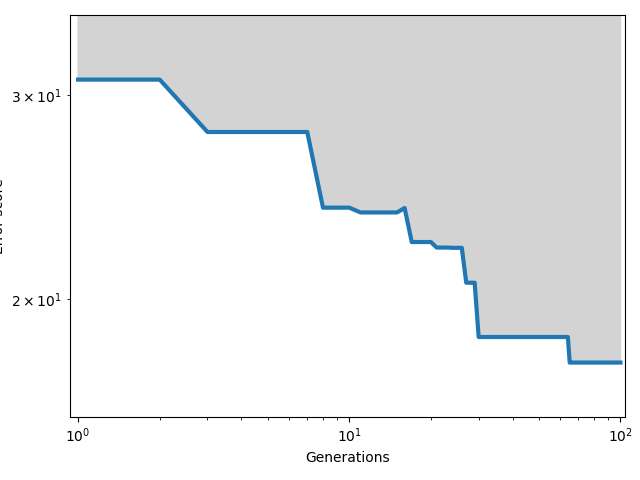

In [12]:
plot_log(log)

In [13]:
best_models = json.load(open('best_models.json'))
pandas.options.display.float_format = '{:,.4g}'.format
bm = pandas.DataFrame(best_models)
bm.T

,0,1,2,3,4,5,6,7,8,9
g_pas.all,0.001181,0.001181,0.001197,0.001185,0.001109,0.001187,0.001181,0.00118,0.001245,0.001185
e_pas.all,-68.58,-68.63,-69.35,-69.32,-70.28,-69.35,-68.6,-68.76,-70.48,-69.69
cm.all,1.471,1.471,1.558,1.474,1.656,1.595,1.52,1.465,1.504,1.448
gbar_kir.somatic,0.0354,0.0354,0.03595,0.03556,0.03241,0.03628,0.03651,0.03599,0.0481,0.0359
shift_kir.somatic,-23.72,-23.72,-24.45,-24.76,-22.58,-23.78,-23.72,-24.18,-27.64,-25
gbar_kir.basal,0.001576,0.001576,0.001498,0.001692,0.0005304,0.001079,0.001346,0.001563,0.0004264,0.001563


<IPython.core.display.Javascript object>


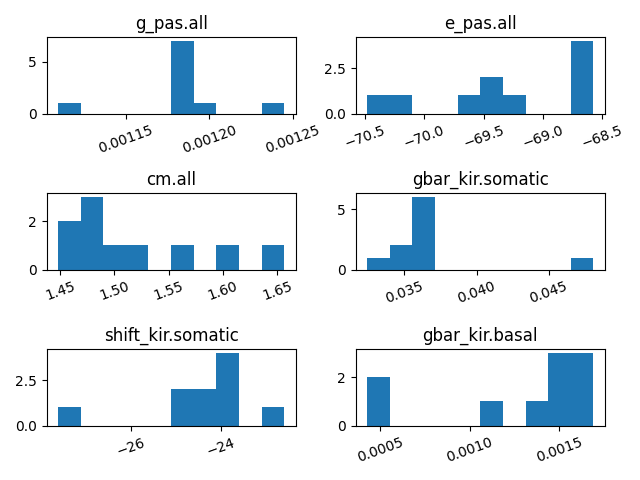

In [14]:
axs = bm.hist(grid=False, xrot=20)
plt.tight_layout();

<IPython.core.display.Javascript object>


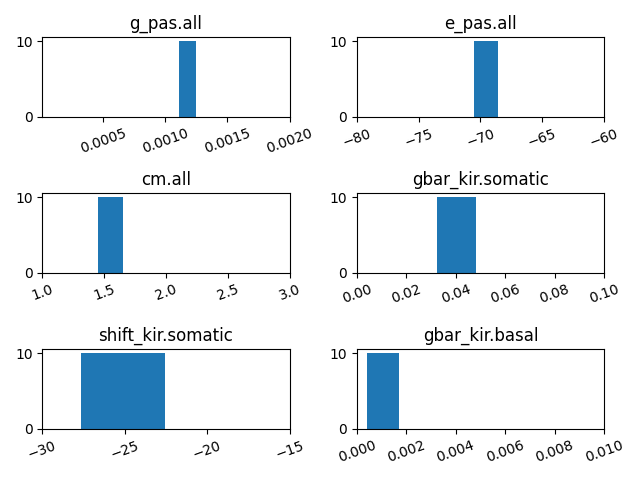

In [15]:
axs = bm.hist(bins=1, grid=False, xrot=20)
for ax, bounds in zip(axs.flatten(), opt_bounds):
        ax.set_xlim(bounds)
plt.tight_layout();

In [16]:
evaluate_all = True
best_objectives = []
if evaluate_all:
    for params in best_models:
        objectives = evaluator.evaluate_with_dicts(params)
        best_objectives.append(objectives)
    df = pandas.DataFrame(best_objectives).T
    df = df.sort_index(axis=0, ascending=False)

<IPython.core.display.Javascript object>


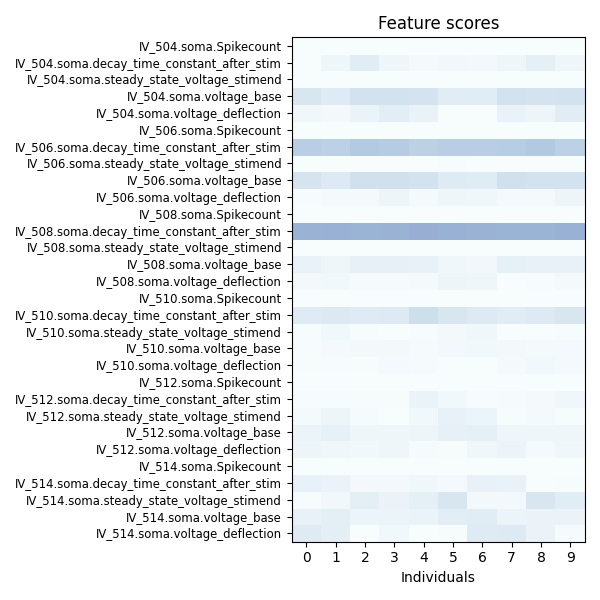

In [17]:
if evaluate_all:
    plot_scores(df, figsize=(6, 6), vmin=0, vmax=10)

## Single-cell simulation

In [18]:
ind = 0
test_parameters = best_models[ind]

In [19]:
test_responses = evaluator.run_protocols(
    protocols=protocols.values(), 
    param_values=test_parameters)

<IPython.core.display.Javascript object>


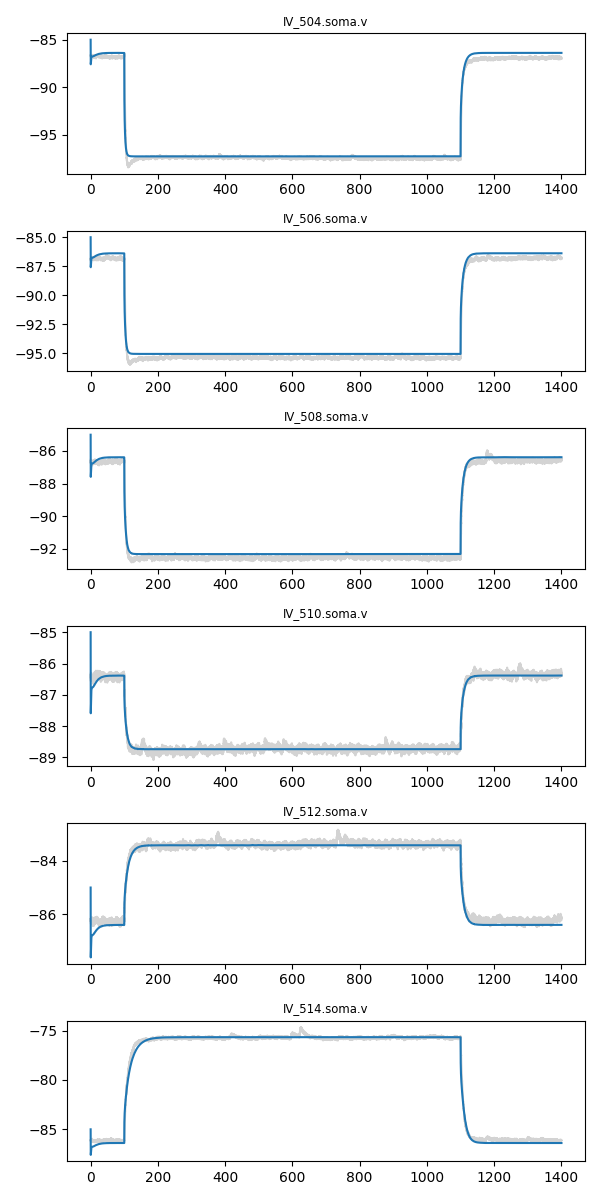

In [20]:
plot_responses(test_responses, expdata=expdata, junction_potential=11.5, figsize=(6,12))

<IPython.core.display.Javascript object>


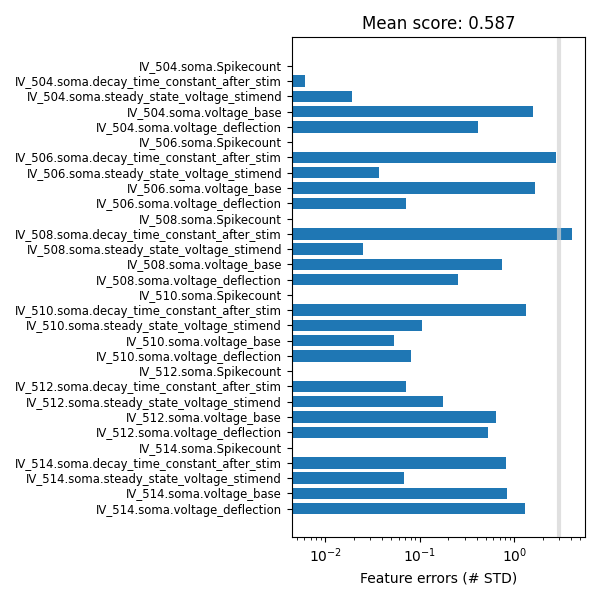

In [21]:
if evaluate_all:
    objectives = best_objectives[ind]
else:
    objectives = evaluator.evaluate_with_dicts(test_parameters)
plot_objectives(objectives, figsize=(6,6))

In [22]:
from numpy.linalg import norm
d = []
for i in range(len(best_models)):
    v = []
    for j in range(len(best_models)):
        p1 = np.array([best_models[i][p] for p in sorted(best_models[i])])
        p2 = np.array([best_models[j][p] for p in sorted(best_models[j])])
        v.append(norm((p1-p2)/(p1+p2)))
    d.append(v)
df = pandas.DataFrame(data=np.round(d,2))
def highlight_low(x):
    def c(v):
        r = int(v/x.max()*255)
        g = int(v/x.max()*128)+127
        b = 255
        return '#%02x%02x%02x' % (r, g, b)
    return ['background-color: %s' % c(v) for v in x]
df.style.apply(highlight_low)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.040000,0.040000,0.500000,0.190000,0.080000,0.010000,0.600000,0.030000
1,0.000000,0.000000,0.040000,0.040000,0.500000,0.190000,0.080000,0.010000,0.600000,0.030000
2,0.040000,0.040000,0.000000,0.070000,0.480000,0.160000,0.060000,0.040000,0.580000,0.040000
3,0.040000,0.040000,0.070000,0.000000,0.530000,0.230000,0.120000,0.040000,0.620000,0.040000
4,0.500000,0.500000,0.480000,0.530000,0.000000,0.350000,0.440000,0.500000,0.260000,0.500000
5,0.190000,0.190000,0.160000,0.230000,0.350000,0.000000,0.110000,0.190000,0.460000,0.190000
6,0.080000,0.080000,0.060000,0.120000,0.440000,0.110000,0.000000,0.080000,0.540000,0.080000
7,0.010000,0.010000,0.040000,0.040000,0.500000,0.190000,0.080000,0.000000,0.590000,0.020000
8,0.600000,0.600000,0.580000,0.620000,0.260000,0.460000,0.540000,0.590000,0.000000,0.590000
9,0.030000,0.030000,0.040000,0.040000,0.500000,0.190000,0.080000,0.020000,0.590000,0.000000


In [23]:
hall_of_fame = []
selected = range(10)
for model in selected:
    hall_of_fame.append(best_models[model])
with open('hall_of_fame.json', 'w') as fp:
    json.dump(hall_of_fame, fp, indent=4, sort_keys=True)